In [1]:
import numpy as np
from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal
import matplotlib.pyplot as plt
from scipy.signal import upfirdn,lfilter
from scipy.special import erfc

# **Modulação GMSK**






In [2]:
fc = 800
OF = 16
N = 100000
a = np.random.randint(2, size=N)

In [3]:
L = 4
Tb = 2
a = np.random.randint(2, size=N)
BT = np.linspace(0, 2, num=10)

**Funções**

In [4]:
def gaussianLPF(BT, Tb, L, k):
  """
  Generate filter coefficients of Gaussian low pass filter (used in gmsk_mod)
  Parameters:
  BT : BT product - Bandwidth x bit period
  Tb : bit period
  L : oversampling factor (number of samples per bit)
  k : span length of the pulse (bit interval)
  Returns:
  h_norm : normalized filter coefficients of Gaussian LPF
  """
  B = BT/Tb # bandwidth of the filter
  # truncated time limits for the filter
  t = np.arange(start = -k*Tb, stop = k*Tb + Tb/L, step = Tb/L)
  h = B*np.sqrt(2*np.pi/(np.log(2)))*np.exp(-2 * (t*np.pi*B)**2 /(np.log(2)))
  h_norm=h/np.sum(h)
  return h_norm

# Função da Modulação

def gmsk_mod(a,fc,L,BT,enable_plot=False):
    """
    Function to modulate a binary stream using GMSK modulation
    Parameters:
        BT : BT product (bandwidth x bit period) for GMSK
        a : input binary data stream (0's and 1's) to modulate
        fc : RF carrier frequency in Hertz
        L : oversampling factor
        enable_plot: True = plot transmitter waveforms (default False)
    Returns:
        (s_t,s_complex) : tuple containing the following variables
            s_t : GMSK modulated signal with carrier s(t)
            s_complex : baseband GMSK signal (I+jQ)
    """ 
    fs = L*fc; Ts=1/fs;Tb = L*Ts; # derived waveform timing parameters
    c_t = upfirdn(h=[1]*L, x=2*a-1, up = L) #NRZ pulse train c(t)
    
    k=1 # truncation length for Gaussian LPF
    h_t = gaussianLPF(BT,Tb,L,k) # Gaussian LPF with BT=0.25
    b_t = np.convolve(h_t,c_t,'full') # convolve c(t) with Gaussian LPF to get b(t)
    bnorm_t = b_t/max(abs(b_t)) # normalize the output of Gaussian LPF to +/-1
    
    h = 0.5;
    # integrate to get phase information
    phi_t = lfilter(b = [1], a = [1,-1], x = bnorm_t*Ts) * h*np.pi/Tb 
    
    I = np.cos(phi_t)
    Q = np.sin(phi_t) # cross-correlated baseband I/Q signals
    
    s_complex = I - 1j*Q # complex baseband representation
    t = Ts* np.arange(start = 0, stop = len(I)) # time base for RF carrier
    sI_t = I*np.cos(2*np.pi*fc*t); sQ_t = Q*np.sin(2*np.pi*fc*t)
    s_t = sI_t - sQ_t # s(t) - GMSK with RF carrier
    
    if enable_plot:
        fig, axs = plt.subplots(2, 4)
        axs[0,0].plot(np.arange(0,len(c_t))*Ts,c_t);
        axs[0,0].set_title('c(t)');axs[0,0].set_xlim(0,40*Tb)
        axs[0,1].plot(np.arange(-k*Tb,k*Tb+Ts,Ts),h_t);
        axs[0,1].set_title('$h(t): BT_b$='+str(BT))
        axs[0,2].plot(t,I,'--');axs[0,2].plot(t,sI_t,'r');
        axs[0,2].set_title('$I(t)cos(2 \pi f_c t)$');axs[0,2].set_xlim(0,10*Tb)
        axs[0,3].plot(t,Q,'--');axs[0,3].plot(t,sQ_t,'r');
        axs[0,3].set_title('$Q(t)sin(2 \pi f_c t)$');axs[0,3].set_xlim(0,10*Tb)
        axs[1,0].plot( np.arange(0,len(bnorm_t))*Ts,bnorm_t);
        axs[1,0].set_title('b(t)');axs[1,0].set_xlim(0,40*Tb)
        axs[1,1].plot(np.arange(0,len(phi_t))*Ts, phi_t);
        axs[1,1].set_title('$\phi(t)$')
        axs[1,2].plot(t,s_t);axs[1,2].set_title('s(t)');
        axs[1,2].set_xlim(0,20*Tb)
        axs[1,3].plot(I,Q);axs[1,3].set_title('Constelação')
        fig.show()        
    return (s_t,s_complex)


# Função da Demodulação

def gmsk_demod(r_complex,L):
  """
  Function to demodulate a baseband GMSK signal
  Parameters:
  r_complex : received signal at receiver front end (complex form - I+jQ)
  L : oversampling factor
  Returns:
  a_hat : detected binary stream
  """
  I = np.real(r_complex); Q = -np.imag(r_complex); # I,Q streams
  z1 = Q * np.hstack((np.zeros(L), I[0:len(I)-L]))
  z2 = I * np.hstack((np.zeros(L), Q[0:len(I)-L]))
  z = z1 - z2
  a_hat = (z[2*L-1:-L:L] > 0).astype(int) # sampling and hard decision
  #sampling indices depend on the truncation length (k) of Gaussian LPF defined in the modulator
  return a_hat

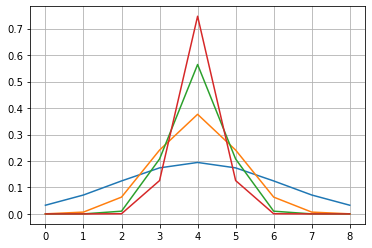

In [5]:
h = gaussianLPF(0.25, 1, L, 1)
h2 = gaussianLPF(0.5, 1, L, 1)
h3 = gaussianLPF(0.75, 1, L, 1)
h4 = gaussianLPF(1, 1, L, 1)
#plt.plot(np.real(h),np.imag(h),'o')
plt.plot(h)
plt.plot(h2)
plt.plot(h3)
plt.plot(h4)
plt.grid()
plt.show()

C:\Users\aldob\AppData\Local\Temp\ipykernel_1552\2635590098.py:72: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


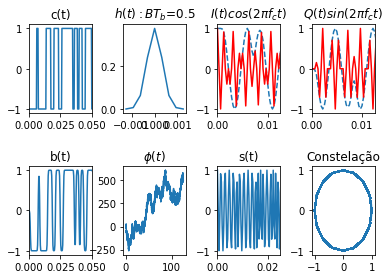

In [6]:
s_tc = gmsk_mod(a,fc,L,0.5, True)
plt.subplots_adjust(left=0.1,
                    bottom=0.15, 
                    right=0.9, 
                    top=0.95, 
                    wspace=0.5, 
                    hspace=0.6)
plt.show()
plt.rcParams['figure.figsize'] = [8, 3]
plt.rcParams['figure.dpi'] = 200  # 200 e.g. is really fine, but slower

**BER**

In [8]:
def BER(x,b):
  numErr = np.sum(abs(x - b))
  return numErr/len(x)

def awgn(s,SNRdB,L=1):
    """
    AWGN channel
    
    Add AWGN noise to input signal. The function adds AWGN noise vector to signal
    's' to generate a resulting signal vector 'r' of specified SNR in dB. It also
    returns the noise vector 'n' that is added to the signal 's' and the power
    spectral density N0 of noise added
    
    Parameters:
        s : input/transmitted signal vector
        SNRdB : desired signal to noise ratio (expressed in dB)
            for the received signal
        L : oversampling factor (applicable for waveform simulation)
            default L = 1.
    Returns:
        r : received signal vector (r=s+n)
    """
    gamma = 10**(SNRdB/10) #SNR to linear scale
    
    if s.ndim==1:# if s is single dimensional vector
        P=L*sum(abs(s)**2)/len(s) #Actual power in the vector
    else: # multi-dimensional signals like MFSK
        P=L*sum(sum(abs(s)**2))/len(s) # if s is a matrix [MxN]
        
    N0=P/gamma # Find the noise spectral density    
    if isrealobj(s):# check if input is real/complex object type
        n = sqrt(N0/2)*standard_normal(s.shape) # computed noise
    else:
        n = sqrt(N0/2)*(standard_normal(s.shape)+1j*standard_normal(s.shape))
    r = s + n # received signal    
    return r


C:\Users\aldob\AppData\Local\Temp\ipykernel_1552\3936052441.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  axs.legend();fig.show()


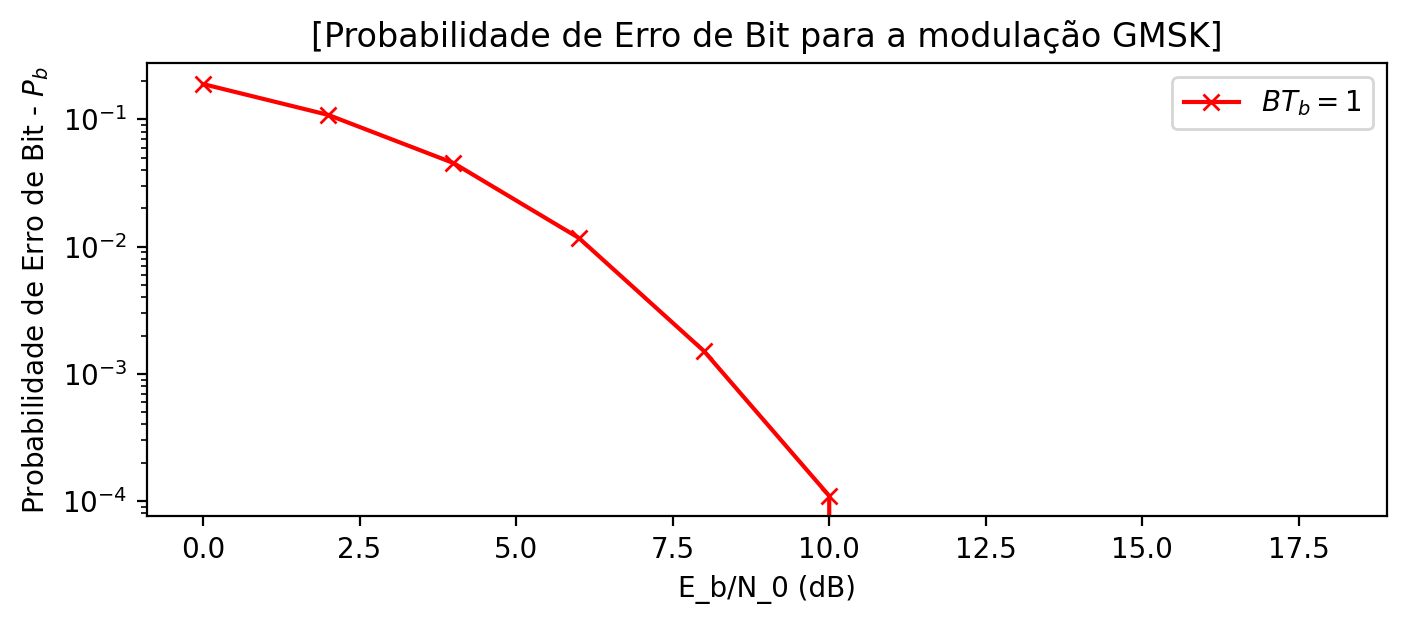

In [11]:
'''
N = 100000 # Number of symbols to transmit
EbN0dB = np.arange(start=-4,stop = 11,step = 2) # Eb/N0 range in dB for simulation
fc = 800 # carrier frequency in Hertz
OF = 32 # oversampling factor, sampling frequency will be fs=OF*fc

BER = np.zeros(len(EbN0dB)) # For BER values for each Eb/N0

a = np.random.randint(2, size=N) # uniform random symbols from 0's and 1's
result = gmsk_mod(a,fc,OF,0.5,False) # MSK modulation
s = result[0]

for i,EbN0 in enumerate(EbN0dB):
  r = awgn(s,EbN0,OF) # refer Chapter section 4.1
  a_hat = gmsk_demod(r,OF) #receiver
  BER[i] = np.sum(a!=a_hat)/N # Bit Error Rate Computation

theoreticalBER = 0.5*erfc(np.sqrt(10**(EbN0dB/10))) # Theoretical bit error rate

#-------------Plots---------------------------
fig, ax = plt.subplots(nrows=1,ncols = 1)
ax.semilogy(EbN0dB,BER,'k*',label='Simulada') # simulated BER
ax.semilogy(EbN0dB,theoreticalBER,'r-',label='Teórica')
ax.set_xlabel(r'$E_b/N_0$ (dB)')
ax.set_ylabel(r'Probabilidade de Erro de Bit - $P_b$')
ax.set_title(['Probabilidade de Erro de Bit para a modulação GMSK'])
ax.legend();fig.show();
'''

N=100000 
EbN0dB = np.arange(start=0,stop = 19, step = 2) # Eb/N0 range in dB for simulation
BTs = [0.1, 0.3 ,0.5, 1] # Gaussian LPF's BT products
fc = 800 # Carrier frequency in Hz (must be < fs/2 and > fg)
L = 16 # oversampling factor

fig, axs = plt.subplots(nrows=1,ncols = 1)
lineColors = ['g','b','k','r']

for i,BT in enumerate(BTs):
  a = np.random.randint(2, size=N) # uniform random symbols from 0's and 1's
  (s_t,s_complex) = gmsk_mod(a,fc,L,BT) # GMSK modulation
  BER = np.zeros(len(EbN0dB)) # For BER values for each Eb/N0

  for j,EbN0 in enumerate(EbN0dB):
    r_complex = awgn(s_complex,EbN0) # refer Chapter section 4.1
    a_hat = gmsk_demod(r_complex,L) # Baseband GMSK demodulation
    BER[j] = np.sum(a!=a_hat)/N # Bit Error Rate Computation

axs.semilogy(EbN0dB,BER,lineColors[i]+'-x',label='$BT_b=$'+str(BT))
axs.set_title('[Probabilidade de Erro de Bit para a modulação GMSK]')
axs.set_xlabel('E_b/N_0 (dB)');axs.set_ylabel('Probabilidade de Erro de Bit - $P_b$')
axs.legend();fig.show()

 **Análise Espectral**

C:\Users\aldob\AppData\Local\Temp\ipykernel_1552\1767127749.py:7: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  w = hanning(nx//na) #// is for integer floor division
C:\Users\aldob\AppData\Local\Temp\ipykernel_1552\1767127749.py:7: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  w = hanning(nx//na) #// is for integer floor division
C:\Users\aldob\AppData\Local\Temp\ipykernel_1552\1767127749.py:7: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  w = hanning(nx//na) #// is for integer floor division
C:\Users\aldob\AppData\Local\Temp\ipykernel_1552\1767127749.py:7: DeprecationWarning: `hanning` is deprecated, use `scipy.signal.windows.hann` instead!
  w = hanning(nx//na) #// is for integer floor division
C:\Users\aldob\AppData\Local\Temp\ipykernel_1552\1767127749.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-

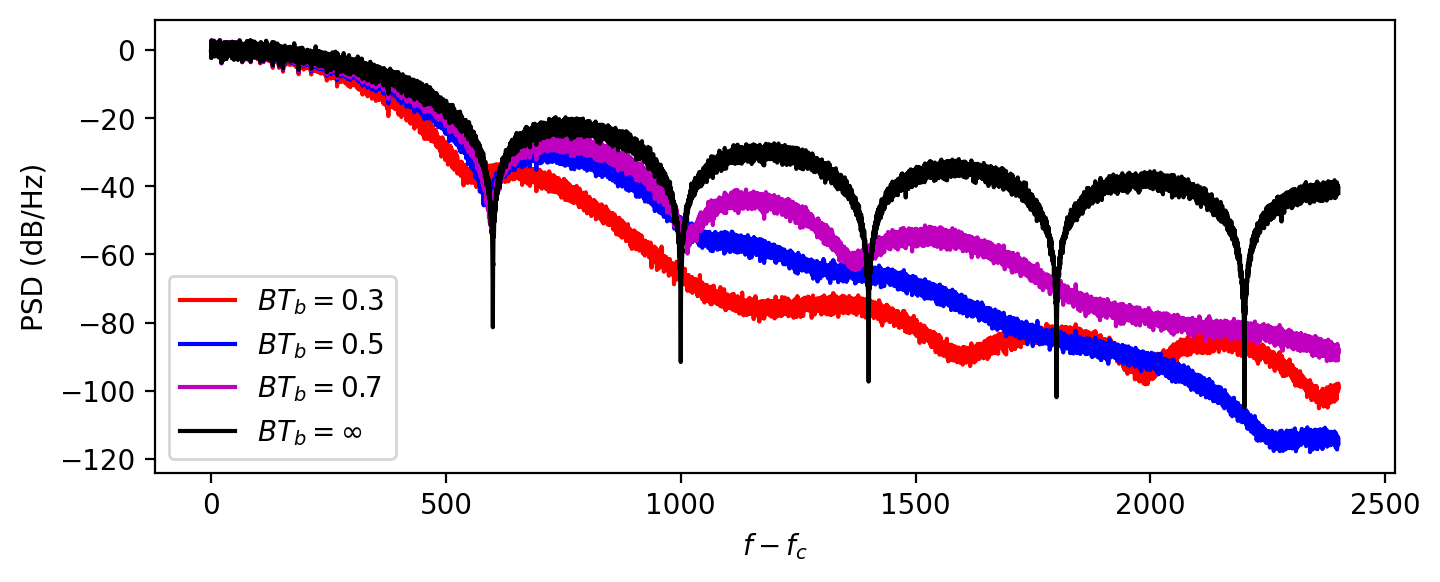

In [13]:
def plotWelchPSD(x,fs,fc,ax = None,color='b', label=None):
   
    from scipy.signal import hanning, welch
    from numpy import log10
    nx = max(x.shape)
    na = 16 # averaging factor to plot averaged welch spectrum
    w = hanning(nx//na) #// is for integer floor division
    # Welch PSD estimate with Hanning window and no overlap
    f, Pxx = welch(x,fs,window = w,noverlap=0)
    indices = (f>=fc) & (f<4*fc)   # To plot PSD from Fc to 4*Fc
    Pxx = Pxx[indices]/Pxx[indices][0] # normalized psd w.r.t Fc
    ax.plot(f[indices]-fc,10*log10(Pxx),color,label=label) #Plot in the given axes

N = 100000 # Number of symbols to transmit
fc = 800 # carrier frequency in Hertz
L = 16 # oversampling factor,use L= Fs/Fc, where Fs >> 2xFc
fs = L*fc
a = np.random.randint(2, size=N) # uniform random symbols from 0's and 1's
#'_':unused output variable
(s1 , _ ) = gmsk_mod(a,fc,L,BT=0.3, enable_plot=False) # BT_b=0.3
(s2 , _ ) = gmsk_mod(a,fc,L,BT=0.5) # BT_b=0.5
(s3 , _ ) = gmsk_mod(a,fc,L,BT=0.7) # BT_b=0.7
(s4 , _ ) = gmsk_mod(a,fc,L,BT=10000) # BT_b=very value value (MSK)
# Compute and plot PSDs for each of the modulated versions
fig, ax = plt.subplots(1, 1)
plotWelchPSD(s1,fs,fc, ax = ax , color = 'r', label = '$BT_b=0.3$')
plotWelchPSD(s2,fs,fc, ax = ax , color = 'b', label = '$BT_b=0.5$')
plotWelchPSD(s3,fs,fc, ax = ax , color = 'm', label = '$BT_b=0.7$')
plotWelchPSD(s4,fs,fc, ax = ax , color = 'k', label = '$BT_b=\infty$')
ax.set_xlabel('$f-f_c$'); ax.set_ylabel('PSD (dB/Hz)')
ax.legend(); fig.show()